<a href="https://colab.research.google.com/github/krutarth45/Quora-Insincere-Question-Classification/blob/master/InsincereTextClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installing Tensorflow

In [1]:
!pip install tensorflow-gpu==2.0.0-rc0

     |████████████████████████████████| 380.5MB 41kB/s 
     |████████████████████████████████| 501kB 39.3MB/s 
     |████████████████████████████████| 4.3MB 44.1MB/s 


In [2]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 /root/kaggle/kaggle.json

chmod: cannot access '/root/kaggle/kaggle.json': No such file or directory


### Extracting dataset from Kaggle.

In [3]:
!kaggle competitions download -c quora-insincere-questions-classification

 38% 6.00M/15.8M [00:00<00:00, 61.7MB/s]
100% 15.8M/15.8M [00:00<00:00, 101MB/s] 
100% 5.95G/5.96G [02:23<00:00, 35.5MB/s]
100% 5.96G/5.96G [02:24<00:00, 44.4MB/s]
 69% 38.0M/54.9M [00:00<00:00, 80.7MB/s]
100% 54.9M/54.9M [00:00<00:00, 139MB/s] 
  0% 0.00/4.09M [00:00<?, ?B/s]
100% 4.09M/4.09M [00:00<00:00, 66.7MB/s]


### Extracting Dataset

In [0]:
## Extracting training dataset.
import zipfile
with zipfile.ZipFile('train.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('sample_data')

In [0]:
## Extracting testing dataset.
with zipfile.ZipFile('test.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('sample_data')

### Importing Libraries

In [0]:
import os
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Conv1D, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Sequential


In [7]:
## Reading Dataset
train_df = pd.read_csv("/content/sample_data/train.csv")
test_df = pd.read_csv("/content/sample_data/test.csv")
print("Train shape : ",train_df.shape)
print("Test shape : ",test_df.shape)

Train shape :  (1306122, 3)
Test shape :  (375806, 2)


### Spliting the training dataset into train and val sample.

In [0]:
## split to train and val
train_df, val_df = train_test_split(train_df, test_size=0.1)

## some config values 
embed_size = 300 # how big is each word vector
max_features = 50000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a question to use

### Fill up the missing values in the text column with 'na'

In [0]:
## fill up the missing values
train_X = train_df["question_text"].fillna("_na_").values
val_X = val_df["question_text"].fillna("_na_").values
test_X = test_df["question_text"].fillna("_na_").values

### Tokenize the text column and convert them to vector sequences

In [0]:
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
val_X = tokenizer.texts_to_sequences(val_X)
test_X = tokenizer.texts_to_sequences(test_X)

### Pad the sequence as needed

In [0]:
## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
val_X = pad_sequences(val_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

## Get the target values
train_y = train_df['target'].values
val_y = val_df['target'].values


### Using Bidirectional GRU Model.
### Embeddings are learnt from scratch here.

In [0]:
## Creating Model
model = Sequential()
model.add(Embedding(max_features, embed_size))
model.add(Bidirectional(GRU(64, return_sequences=True)))
model.add(GlobalMaxPool1D())
model.add(Dense(16, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))

### Compiling

In [13]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
## Printing summary of the model
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         15000000  
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         140544    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                2064      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 15,142,625
Trainable params: 15,142,625
Non-trainable params: 0
____________________________________________

### Training the model

In [14]:
history = model.fit(train_X, train_y, batch_size=512, epochs=2, validation_data=(val_X, val_y))

Train on 1175509 samples, validate on 130613 samples
Epoch 1/2
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
1175509/1175509 [==============================] - 386s 328us/sample - loss: 0.1255 - accuracy: 0.9532 - val_loss: 0.1076 - val_accuracy: 0.9574
Epoch 2/2
1175509/1175509 [==============================] - 375s 319us/sample - loss: 0.1011 - accuracy: 0.9599 - val_loss: 0.1082 - val_accuracy: 0.9580


### Predicting for the test data

In [0]:
## Predicting for the test data
pred = model.predict(test_X)

In [0]:
import matplotlib.pyplot as plt
## Plotting the curve for the accuracy and the loss
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  plt.plot(epochRange,history.history['accuracy'])
  plt.plot(epochRange,history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train','Validation'],loc='upper left')
  plt.show()

  plt.plot(epochRange,history.history['loss'])
  plt.plot(epochRange,history.history['val_loss'])
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train','Validation'],loc='upper left')
  plt.show()

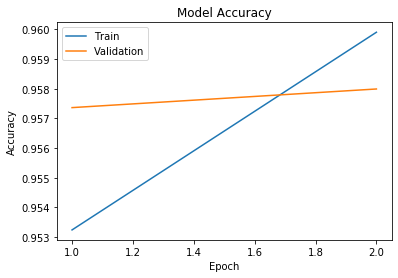

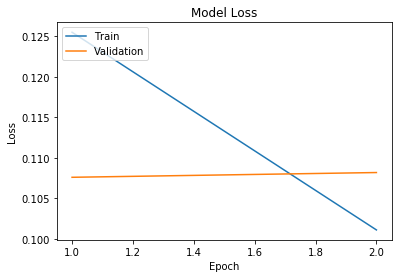

In [17]:
plotLearningCurve(history,2)

In [0]:
## Extracting Embeddings dataset.
with zipfile.ZipFile('embeddings.zip', 'r') as zip_ref:
    zip_ref.extractall('sample_data')

### GloVe Embeddings

In [19]:
## Extracting the embeddings
EMBEDDING_FILE = '/content/sample_data/glove.840B.300d/glove.840B.300d.txt'
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE) if len(o)>100)

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


In [0]:
## Creating Model
model = Sequential()
model.add(Embedding(max_features, embed_size, weights=[embedding_matrix]))
model.add(Bidirectional(GRU(64, return_sequences=True)))
model.add(GlobalMaxPool1D())
model.add(Dense(16, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))

In [0]:
## Compiling
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
## Training
history = model.fit(train_X, train_y, batch_size=512, epochs=2, validation_data=(val_X, val_y))

Train on 1175509 samples, validate on 130613 samples
Epoch 1/2
1175509/1175509 [==============================] - 425s 362us/sample - loss: 0.1161 - accuracy: 0.9549 - val_loss: 0.1020 - val_accuracy: 0.9589
Epoch 2/2
1175509/1175509 [==============================] - 421s 359us/sample - loss: 0.0967 - accuracy: 0.9620 - val_loss: 0.1021 - val_accuracy: 0.9595


In [0]:
## Prediction
pred1 = model.predict(test_X)

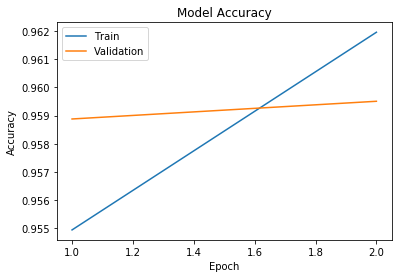

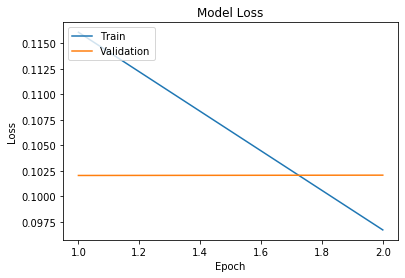

In [24]:
plotLearningCurve(history,2)

### Paragram Embeddings

In [25]:
## Extracting the Paragram embeddings
EMBEDDING_FILE = '/content/sample_data/paragram_300_sl999/paragram_300_sl999.txt'
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE, encoding="utf8", errors='ignore') if len(o)>100)

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


In [0]:
## Creating Model
model = Sequential()
model.add(Embedding(max_features, embed_size, weights=[embedding_matrix]))
model.add(Bidirectional(GRU(64, return_sequences=True)))
model.add(GlobalMaxPool1D())
model.add(Dense(16, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))

In [0]:
## Compiling
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
history = model.fit(train_X, train_y, batch_size=512, epochs=2, validation_data=(val_X, val_y))

Train on 1175509 samples, validate on 130613 samples
Epoch 1/2
1175509/1175509 [==============================] - 382s 325us/sample - loss: 0.1173 - accuracy: 0.9549 - val_loss: 0.1025 - val_accuracy: 0.9592
Epoch 2/2
1175509/1175509 [==============================] - 375s 319us/sample - loss: 0.0974 - accuracy: 0.9613 - val_loss: 0.1024 - val_accuracy: 0.9593


In [0]:
pred2 = model.predict(test_X)

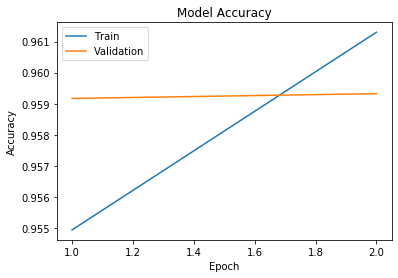

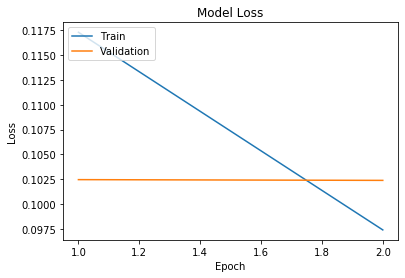

In [32]:
plotLearningCurve(history,2)

# Best result is obtained through Paramgram Embeddings as loss for both training and validating is reducing substancially and having a high accuracy of almost 96%.